In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_to_csv = os.path.join('..', 'experiments', 'Taylor_metrics_processed.csv')

In [3]:
df = pd.read_csv(path_to_csv, index_col=0)

In [4]:
df.head()

,run_id,MSEc,sigma_pred,sigma_true,seed,wds,placement,obs_rat,adjacency,tag,num,model,corr_coeff
0,anytown-fixrnd-0.05-binary-def-1-orig,329.145719,18.142374,18.142374,0,anytown,fixrnd,0.05,binary,def,1,orig,1.000000
1,anytown-fixrnd-0.05-binary-def-1-gcn,305.902143,17.431887,18.142374,0,anytown,fixrnd,0.05,binary,def,1,gcn,0.967262
2,anytown-fixrnd-0.05-binary-def-2-gcn,289.265015,16.723429,18.142374,0,anytown,fixrnd,0.05,binary,def,2,gcn,0.953403
3,anytown-fixrnd-0.05-binary-def-3-gcn,274.175302,16.311682,18.142374,0,anytown,fixrnd,0.05,binary,def,3,gcn,0.926479
4,anytown-fixrnd-0.05-binary-def-4-gcn,277.586525,16.270504,18.142374,0,anytown,fixrnd,0.05,binary,def,4,gcn,0.940380


# Preprocessing

In [5]:
df = df[~df['run_id'].str.contains('fixrnd')] # dropping old results
df['test_csv'] = df['run_id']
df['test_csv'] = df['test_csv'].apply(lambda fn: fn[:-4]+'_tst.csv')

# Loading test results

In [6]:
def read_test_result(fn):
    path_to_res = os.path.join('..', 'experiments', 'logs', fn)
    res_df = pd.read_csv(path_to_res, header=None, index_col=None, skiprows=1)
    res_dict = dict()
    for i in range(len(res_df)):
        res_dict[res_df.iloc[i][0]] = res_df.iloc[i][1]
    return res_dict

In [7]:
tempo_df = pd.DataFrame([read_test_result(fn) for fn in df['test_csv']], index=df['run_id'])
df.set_index('run_id', inplace=True)
df = df.join(tempo_df)

# Unique algo ids

In [8]:
ids = df.index.tolist()
algos = set()
for elem in ids:
    algos.add(elem.split('-')[1])

In [9]:
print(algos)

{'hydrodist', 'master', 'random', 'hdvar', 'dist', 'xrandom', 'hds'}


* master: entry nodes of tanks and reservoirs.
* random: nodes selected according to the uniform random distribution. Budget is the sum of the num. of master nodes and the original budget.
* xrandom: master + nodes selected according to the uniform random distribution.
* dist: shortest path weighted with pipe length.
* hydrodist: shortest path weighted with hydraulic distance.
* hdvar: shortest path weighted with nodal head variation.
* hds: shortest path weighted with nodal sensitivity.

# Barplots

In [10]:
def filter_df(df):
    subdf = df[df['placement'] != 'random']
    subdf = subdf.drop(
        ['num', 'model',
         'MSEc', 'sigma_pred', 'sigma_true', 'seed', 'obs_rat', 'adjacency', 'tag', 'corr_coeff', 'test_csv'],
        axis = 1
    )
    data = {'Water distribution system': [], 'Relative error, %': [], 'Sensor selection': []}
    for i in range(len(subdf)):
        row = subdf.iloc[i]
        data['Water distribution system'].append(row['wds'])
        data['Relative error, %'].append(row['tst_rel_err_h']*100)
        data['Sensor selection'].append(row['placement'])
        err_df = pd.DataFrame(data=data)
        err_df = err_df.replace('master', 'Master nodes only')
        err_df = err_df.replace('dist', 'Distance')
        err_df = err_df.replace('hydrodist', 'Hydraulic distance')
        err_df = err_df.replace('hds', 'Hydrodynamic sensitivity')
        err_df = err_df.replace('hdvar', 'Head variance')
        err_df = err_df.replace('xrandom', 'Random choice')
        err_df = err_df.replace('anytown', 'Anytown')
        err_df = err_df.replace('ctown', 'C-Town')
        err_df = err_df.replace('richmond', 'Richmond')
    return err_df

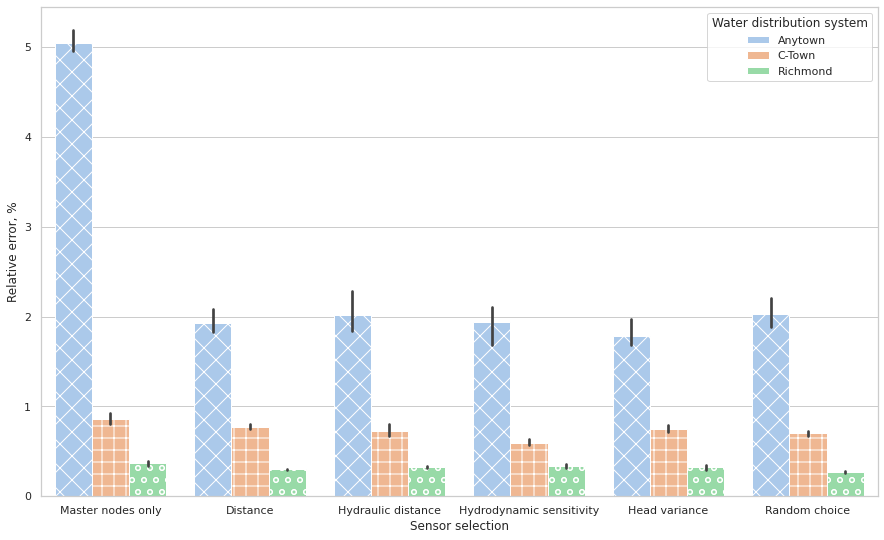

In [11]:
subdf = filter_df(df)

sns.set(rc={'figure.figsize':(15,9)})
sns.set_theme(style='whitegrid', palette='pastel')
bar = sns.barplot(data=subdf, x='Sensor selection', y='Relative error, %', hue='Water distribution system', dodge=True)

hatches = ['x']*6 + ['+']*6 + ['o']*6
for i,thisbar in enumerate(bar.patches):
    thisbar.set_hatch(hatches[i])

plt.show()